In [1]:
import numpy as np
import pandas as pd
import string

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!pip install wordcloud



import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import STOPWORDS

In [4]:
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [5]:
train = pd.read_csv(r'C:\Users\naimu\Music\Toxic Comment Classification\Dataset\train.csv')
test = pd.read_csv(r'C:\Users\naimu\Music\Toxic Comment Classification\Dataset\validation.csv')
test_process = pd.read_csv(r'C:\Users\naimu\Music\Toxic Comment Classification\Dataset\validation-processed.csv')
sample = pd.read_csv(r'C:\Users\naimu\Music\Toxic Comment Classification\Dataset\Submission.csv')
target = pd.read_csv(r'C:\Users\naimu\Music\Toxic Comment Classification\Dataset\Test_Lebel.csv')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [8]:
test_process.head()

,id,comment_text,lang,toxic,input_word_ids,input_mask,all_segment_id
0,0,Este usuario ni siquiera llega al rango de ...,es,0,"(101, 12515, 82849, 10414, 10294, 39190, 10113...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Il testo di questa voce pare esser scopiazzato...,it,0,"(101, 10282, 29346, 10120, 14508, 19696, 22606...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1,"(101, 32286, 119, 101911, 11419, 27119, 10797,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0,"(101, 11916, 10824, 71339, 10245, 15499, 24542...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0,"(101, 47197, 20267, 10371, 14349, 66513, 31268...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
sample.head()

,id,toxic
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [10]:
target.head()

,id,toxic
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [11]:
train['y'] = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) > 0
train.drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], inplace=True, axis=1)

In [12]:
train.head()

,id,comment_text,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False


In [13]:
train.y.unique()

array([False,  True])

<Axes: >

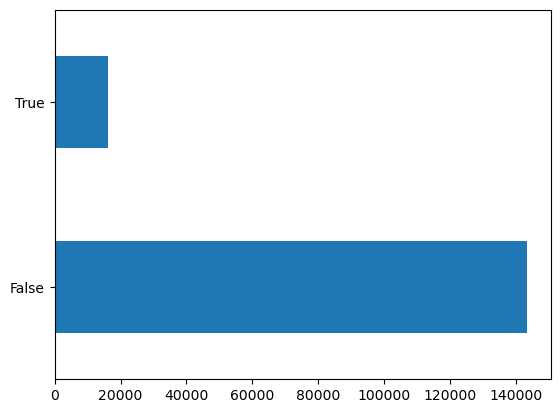

In [14]:
train.y.value_counts().plot(kind='barh')

In [15]:
#Handling Imbalanced Dataset

In [16]:
count_of_toxic_comments =  train[train.y != 0].shape[0]
count_of_toxic_comments

16225

In [17]:
train_toxic = train[train.y != 0]
train_non_toxic = train[train.y == 0].sample(count_of_toxic_comments)

In [18]:
df = pd.concat([train_toxic, train_non_toxic])
df

,id,comment_text,y
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,True
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",True
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,True
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",True
...,...,...,...
108575,44783a7e0c5eeef9,I was bold and reverted the article to version...,False
147925,43ef5fbb02be273a,image\n\nmade ya look....... big smile\n\n-)\n...,False
28416,4b3d745af7245d40,", 26 July 2007 (UTC)\n\nDone. – (talk) (rando...",False
31071,528ae515d2d8fb55,"""{| style=""""background-color:#F5FFFA; padding:...",False


<Axes: >

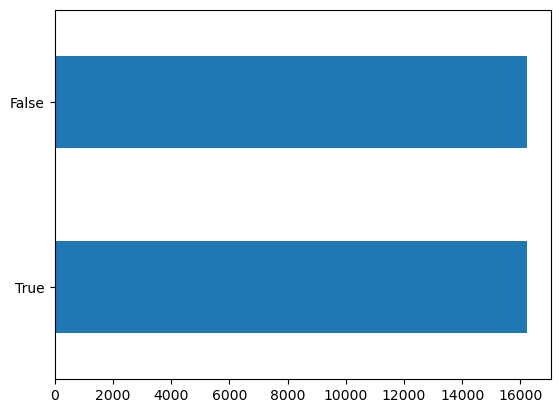

In [19]:
df.y.value_counts().plot(kind='barh')

In [20]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [21]:
df.head()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True,8,8,4,4.625000,44,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,True,53,50,22,5.018868,319,24
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",True,10,10,3,4.600000,57,5
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,True,117,88,54,4.478632,648,28
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",True,8,8,3,4.125000,40,2


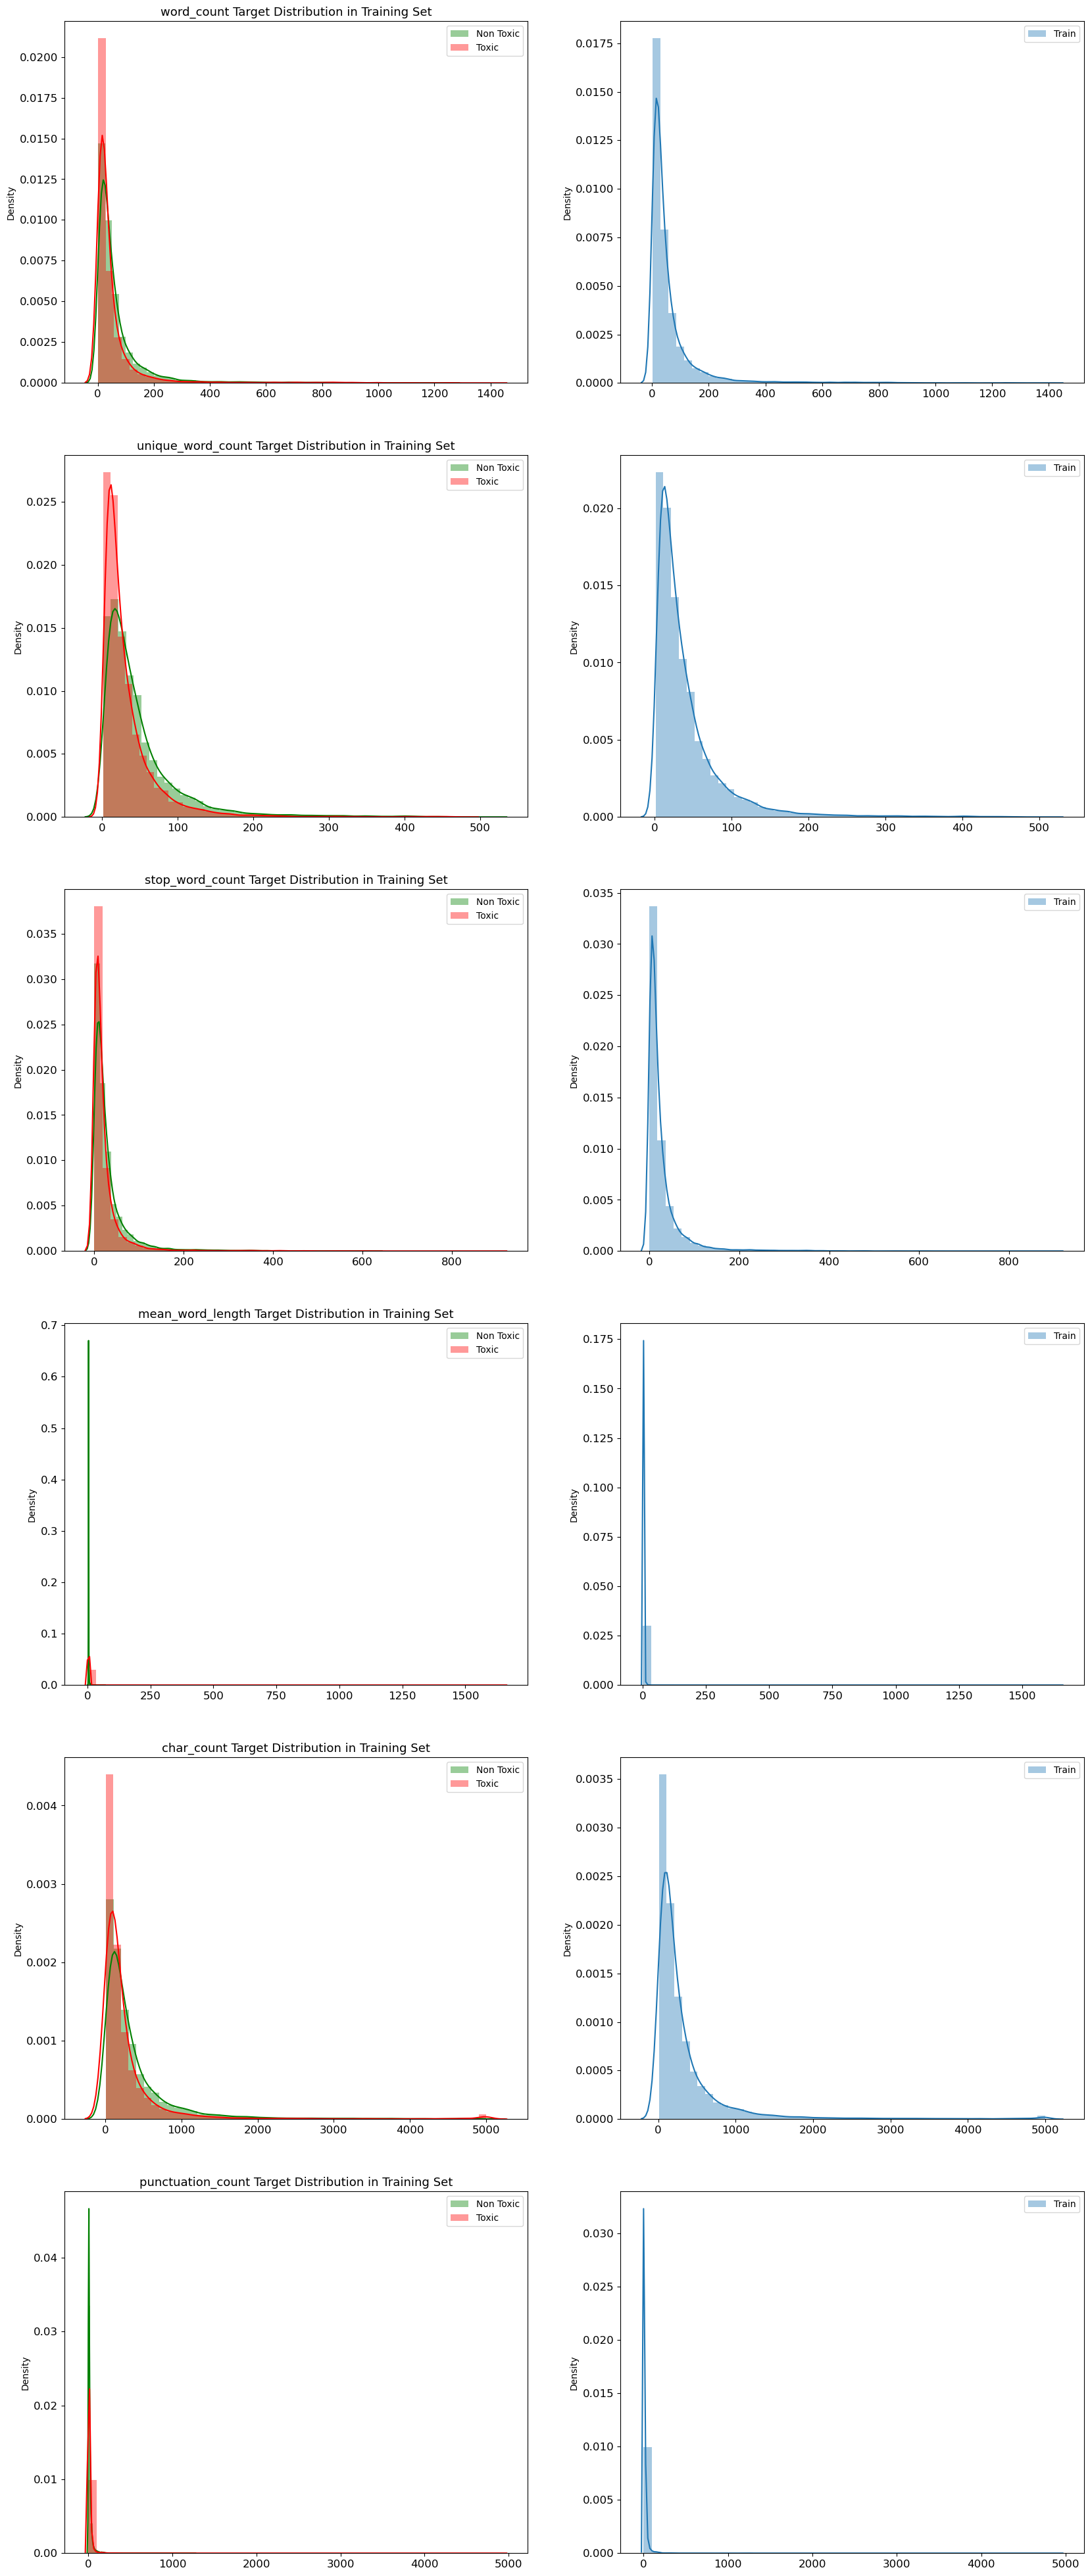

In [22]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length','char_count', 'punctuation_count']
TOXIC_COMMENTS = df['y'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df.loc[~TOXIC_COMMENTS][feature], label='Non Toxic', ax=axes[i][0], color='green')
    sns.distplot(df.loc[TOXIC_COMMENTS][feature], label='Toxic', ax=axes[i][0], color='red')

    sns.distplot(df[feature], label='Train', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)

plt.show()

In [23]:
df.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
count,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000
mean,60.086841,41.078490,27.140586,5.032367,349.487119,15.250539
std,101.642560,48.715406,46.283114,15.110127,597.491521,62.034206
min,1.000000,1.000000,0.000000,1.000000,8.000000,0.000000
25%,13.000000,12.000000,5.000000,4.210526,76.000000,3.000000
50%,29.000000,26.000000,13.000000,4.605263,167.000000,7.000000
75%,63.000000,50.000000,30.000000,5.037037,360.000000,15.000000
max,1411.000000,512.000000,902.000000,1655.000000,5000.000000,4942.000000


In [24]:
# Remove stopwords & convert to lower case
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

# Remove Punctuations
df["comment_text"] = df['comment_text'].str.replace('[^\w\s]','')
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
108575,44783a7e0c5eeef9,bold reverted article version 30 august 2012 s...,False,44,43,16,4.772727,253,6
147925,43ef5fbb02be273a,image made ya look big smile beckjord,False,8,8,0,5.000000,50,9
28416,4b3d745af7245d40,26 july 2007 utc done talk random 1247,False,10,10,0,4.100000,52,9
31071,528ae515d2d8fb55,stylebackgroundcolorf5fffa padding0 cellpaddi...,False,275,187,87,6.429091,2058,179
22879,3c70d1936235a796,veesicleveesicle talk contribs 0555 19 march 2007,False,7,7,0,7.428571,58,9


In [25]:
X = df.drop(['y'], axis=1)
y = df['y']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
X_train.head()

,id,comment_text,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
89549,ef847a82cb1b8b5b,whoever takes wikipedia current state valid s...,93,71,38,4.612903,524,24
134551,cf8b1d1bd9b40560,you bit slow uptake apparently you,15,13,9,4.066667,77,5
48706,8238c949bd306da1,pov tag hiya added comments antimormonism tal...,51,43,21,4.509804,284,13
132353,c4432546c4f726ce,arafat died today arafat died please somebody ...,38,32,12,4.473684,209,9
45438,7980badbf006ae2e,everybody everybody ambergris undigested part ...,19,18,7,5.684211,126,8


In [28]:
X_train = X_train.comment_text.values
X_test = X_test.comment_text.values

In [29]:
y_train.head()

89549      True
134551    False
48706     False
132353    False
45438     False
Name: y, dtype: bool

In [30]:
OOV_TOKEN = '<OOV>'
VOCAB_SIZE = 10000
MAX_LEN = 100
EMBEDDING_DIM = 100

In [31]:
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token=OOV_TOKEN
)
tokenizer.fit_on_texts(X_train)

In [32]:
len(tokenizer.word_index)

60881

In [33]:
###  Convert text to padded sequences

In [34]:
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(
    train_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post'
)



In [35]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post'
)

In [36]:
test_padded.shape

(10709, 100)

In [37]:
model = tf.keras.Sequential([
  Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    LSTM(64),
    Dropout(0.2),
  Dense(16, activation='relu'),
    Dropout(0.2),
  Dense(1,activation='sigmoid')
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,043,297
Trainable params: 1,043,297
Non-

In [40]:
es = EarlyStopping(patience=3, 
                   monitor='loss', 
                   restore_best_weights=True, 
                   mode='min', 
                   verbose=1)

In [41]:
hist = model.fit(
    train_padded,
    y = y_train,
    validation_data=(test_padded, y_test),
    epochs=15,
    callbacks=es
)

Epoch 1/15
680/680 [==============================] - 36s 51ms/step - loss: 0.6831 - accuracy: 0.5295 - val_loss: 0.6893 - val_accuracy: 0.5235
Epoch 2/15
680/680 [==============================] - 32s 47ms/step - loss: 0.6781 - accuracy: 0.5307 - val_loss: 0.6875 - val_accuracy: 0.5207
Epoch 3/15
680/680 [==============================] - 32s 47ms/step - loss: 0.6191 - accuracy: 0.6280 - val_loss: 0.6239 - val_accuracy: 0.6322
Epoch 4/15
680/680 [==============================] - 32s 48ms/step - loss: 0.5600 - accuracy: 0.7188 - val_loss: 0.5826 - val_accuracy: 0.7831
Epoch 5/15
680/680 [==============================] - 34s 50ms/step - loss: 0.5071 - accuracy: 0.7883 - val_loss: 0.4984 - val_accuracy: 0.8032
Epoch 6/15
680/680 [==============================] - 34s 50ms/step - loss: 0.4755 - accuracy: 0.8181 - val_loss: 0.5138 - val_accuracy: 0.7878
Epoch 7/15
680/680 [==============================] - 32s 47ms/step - loss: 0.5953 - accuracy: 0.6529 - val_loss: 0.6760 - val_accuracy:

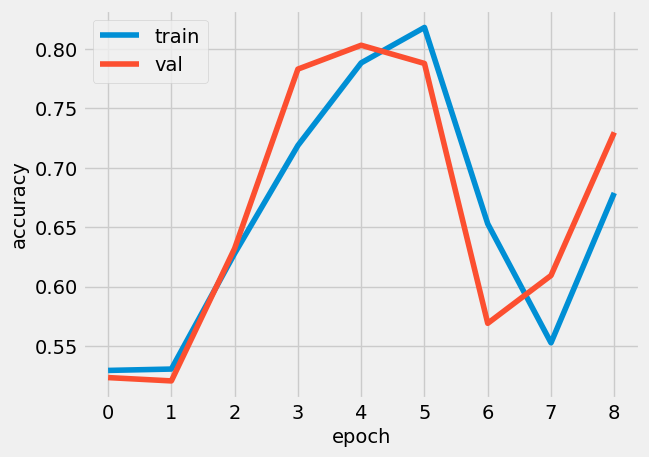

In [43]:
plt.style.use('fivethirtyeight')

# visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()  

In [44]:
target.head()

,id,toxic
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [45]:
df_target = target

In [47]:
print(df_target.columns)

Index(['id', 'toxic'], dtype='object')


In [49]:
# Convert 'toxic' column to string type
df_target['toxic'] = df_target['toxic'].astype(str)

# Remove stopwords & convert to lower case
df_target['id'] = df_target['toxic'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

# Remove Punctuations
df_target["toxic"] = df_target['toxic'].str.replace('[^\w\s]','')
df_target.head()

,id,toxic
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [51]:
# Assuming 'toxic' is the column containing the text data in df_target
target_seq = tokenizer.texts_to_sequences(df_target['toxic'].values)
target_padded = pad_sequences(
    target_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post'
)


In [52]:
result = model.predict(target_padded)

1995/1995 [==============================] - 20s 10ms/step


In [53]:
sample

,id,toxic
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
63807,63807,0.5
63808,63808,0.5
63809,63809,0.5
63810,63810,0.5


In [54]:
target['score'] = result

In [56]:
# Check the column names in the DataFrame
print(target.columns)

# Ensure the column names exist in the DataFrame
if all(col in target.columns for col in ['comment_id', 'score']):
    # Save to CSV
    target[['comment_id', 'score']].to_csv('./submission.csv', index=False)
else:
    print("Columns not found in the DataFrame.")


Index(['id', 'toxic', 'score'], dtype='object')
Columns not found in the DataFrame.


In [42]:
########   References   #####

###  EDA - NLP with Disaster Tweets - EDA, Cleaning and BERT:

#This notebook focuses on Exploratory Data Analysis (EDA), cleaning, and utilizing BERT (Bidirectional Encoder Representations from Transformers) for Natural Language Processing (NLP) tasks on disaster tweets.
#It likely includes sections for data exploration, data cleaning, text preprocessing, and model implementation using BERT.
#BERT is a powerful pre-trained NLP model known for its effectiveness in various NLP tasks.


###  Notebook Formatting - [V7] Shopee InDepth EDA: One stop for all your needs:

#This notebook emphasizes providing an in-depth Exploratory Data Analysis (EDA) on a dataset related to Shopee, an e-commerce platform.
#It is formatted to provide a comprehensive dataset overview, covering various aspects such as data distribution, feature analysis, and potential insights for business decisions.
#The notebook likely includes detailed visualizations, statistical analysis, and narrative explanations to aid in understanding the dataset.


###  Simple LSTM With Word2Vec:

#This notebook focuses on implementing a simple Long Short-Term Memory (LSTM) model using Word2Vec embeddings for NLP tasks.
#LSTM is a recurrent neural network (RNN) known for handling sequential data effectively.
#Word2Vec is a popular word embedding technique representing words in a continuous vector space, capturing semantic relationships between words.
#The notebook likely includes sections for data preprocessing, model architecture definition, training, evaluation, and potential comparison with other models.